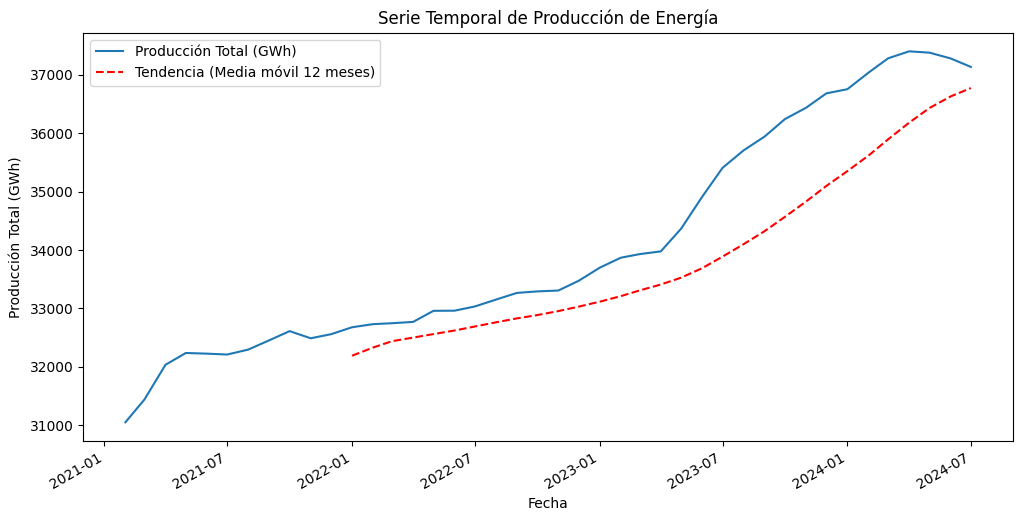

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=423.037, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=411.559, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=414.476, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=441.979, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=409.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=411.468, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=411.671, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=411.673, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=413.823, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=413.673, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=413.443, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12] intercept
Total fit time: 2.931 seconds
                             

c:\Users\ed150\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ed150\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ed150\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


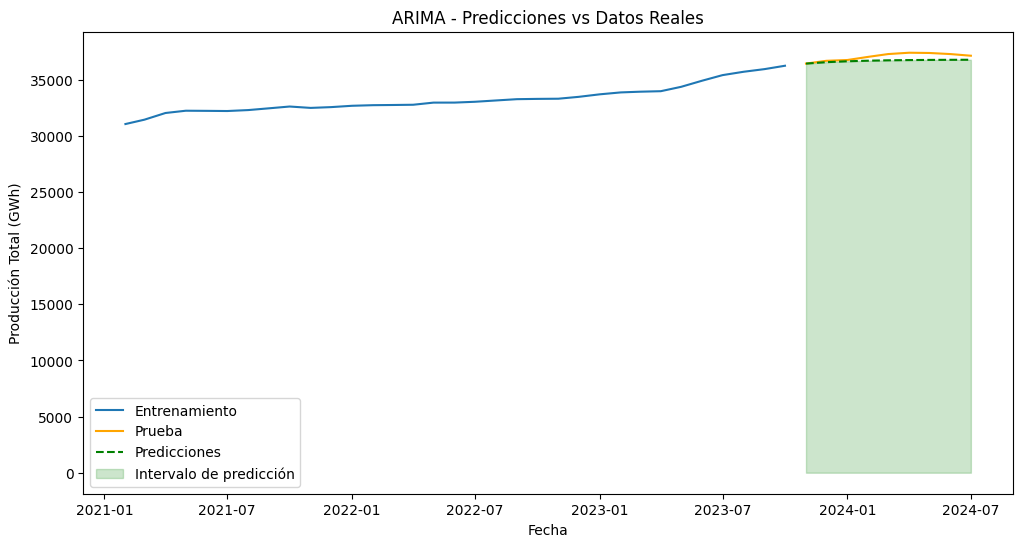

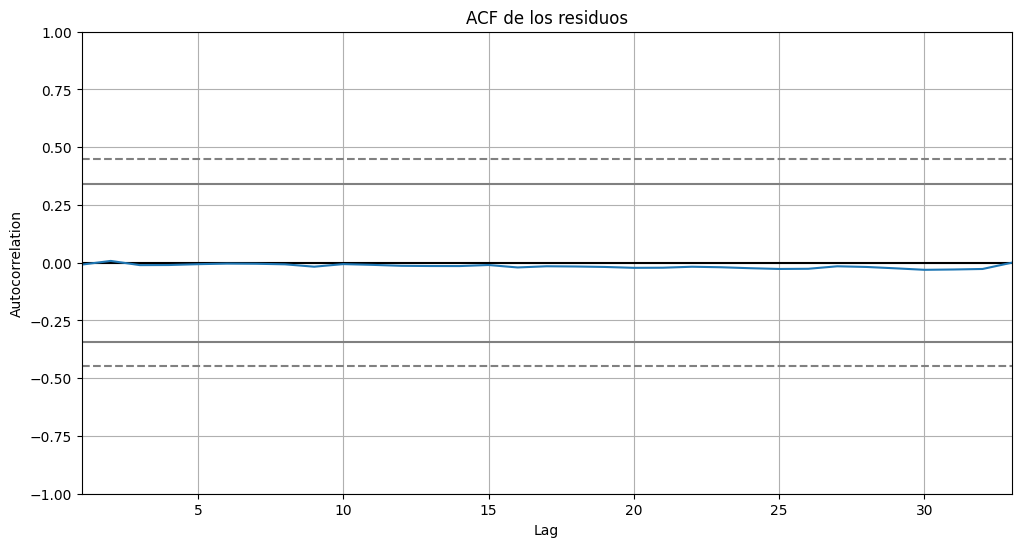

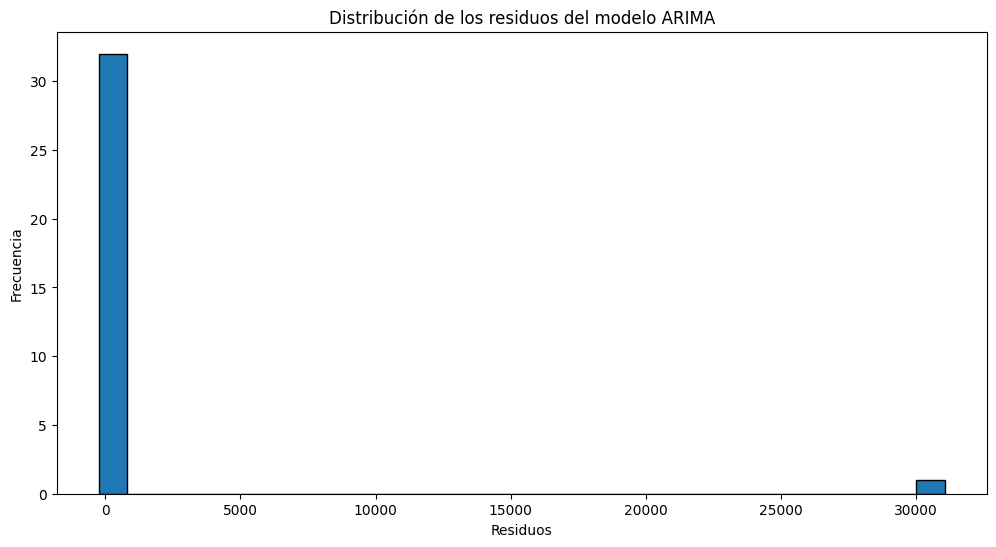

Predicciones guardadas en 'forecast_results.csv'


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import numpy as np

# Cargar el archivo CSV
file_path = "C:\\UNIR\\Arima_Model\\dataset_produccion.csv"
dataset = pd.read_csv(file_path)

# Diccionario para traducir los meses
meses_traducidos = {
    'Enero': 'January', 'Febrero': 'February', 'Marzo': 'March',
    'Abril': 'April', 'Mayo': 'May', 'Junio': 'June',
    'Julio': 'July', 'Agosto': 'August', 'Septiembre': 'September',
    'Octubre': 'October', 'Noviembre': 'November', 'Diciembre': 'December'
}

# Traducir los meses
dataset['Mes'] = dataset['Mes'].replace(meses_traducidos)

# Consolidar duplicados sumando la Producción Total por mes y año
aggregated_df = dataset.groupby(['Mes', 'Año'], as_index=False).agg({
    'Producción Total (GWh)': 'sum'
})

# Crear la columna de fecha
aggregated_df['Date'] = pd.to_datetime(aggregated_df['Mes'] + ' ' + aggregated_df['Año'].astype(str), format='%B %Y')

# Establecer la columna 'Date' como índice y ordenar
aggregated_df = aggregated_df.sort_values('Date').set_index('Date')

# Seleccionar la serie temporal para el modelo
series = aggregated_df['Producción Total (GWh)']

# Verificar valores faltantes
if series.isnull().sum() > 0:
    series = series.fillna(method='ffill')

# Visualizar la serie temporal con tendencia
plt.figure(figsize=(12, 6))
plt.plot(series, label="Producción Total (GWh)")
series.rolling(12).mean().plot(label="Tendencia (Media móvil 12 meses)", linestyle="--", color="red")
plt.title("Serie Temporal de Producción de Energía")
plt.xlabel("Fecha")
plt.ylabel("Producción Total (GWh)")
plt.legend()
plt.show()

# Dividir en datos de entrenamiento y prueba
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Ajuste automático de los parámetros con Auto-ARIMA
stepwise_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())

# Entrenar modelo ARIMA con los parámetros seleccionados por Auto-ARIMA
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

# Predicciones
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Visualización de predicciones vs datos reales
plt.figure(figsize=(12, 6))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Prueba", color='orange')
plt.plot(forecast, label="Predicciones", linestyle="--", color='green')
plt.fill_between(test.index, forecast, color='green', alpha=0.2, label="Intervalo de predicción")
plt.title("ARIMA - Predicciones vs Datos Reales")
plt.xlabel("Fecha")
plt.ylabel("Producción Total (GWh)")
plt.legend()
plt.show()

# Diagnóstico del modelo: ACF de los residuos
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.title("ACF de los residuos")
pd.plotting.autocorrelation_plot(residuals)
plt.show()

# Diagnóstico del modelo: Distribución de los residuos
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Distribución de los residuos del modelo ARIMA")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()

# Guardar resultados del modelo
forecast.to_csv("C:\\UNIR\\Arima_Model\\forecast_results.csv")
print("Predicciones guardadas en 'forecast_results.csv'")
